# Optimum Multi-Parameter Water Mass Analysis

**The contents of this notebook will perform the following:**<br>
1) Subset  <br>
2) More stuff

## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import math
import xarray as xr
import gsw
import sys
import pyompa
from IPython.utils import io
import concurrent.futures

## Determine End-Members: Central Water

In [2]:
#                              temp      sal     oxy
NWACW =       ["NWACW",        15.59,   36.15,   195]    # Warmer and saltier, high oxygen
SWACW =       ["SWACW",        11.65,   35.08,   217]    # Colder and fresher, high oxygen
SEACW =       ["SEACW",        10.50,   35.02,    86]    # lowest oxygen


def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "temperature", "salinity", "oxygen"])
    df["mass"] = 1
    return df

central_water_FK_endmemberdf = prepare_endmember_df([NWACW, SWACW, SEACW])
central_water_FK_endmemberdf

,endmember_name,temperature,salinity,oxygen,mass
0,NWACW,15.59,36.15,195,1
1,SWACW,11.65,35.08,217,1
2,SEACW,10.50,35.02,86,1


## OMPA Settings

In [3]:
#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
        always_positive=True #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]


# paramweightings = {
#     "temperature": 24.0,
#     "salinity": 24.0,
#     "mass": 24.0,
#     "oxygen": 7.0,
# }

paramweightings = {
    "temperature": 158.7,
    "salinity": 154.3,
    "mass": 158.7,
    "oxygen": 35.7,
}

settings = {
    "param_names": ["temperature", "salinity",
                    "oxygen", "mass"],
    "convertedparam_groups": convertedparamgroups,
    "param_weightings": paramweightings,
}


# #sample varying parameter weightings
# sampled_weightings = []
# for i in range(num_samples):
#     rand_weighting = dict([
#         (key, rng.uniform(value*0.8, value*1.2))
#         for key,value in base_weighting.items()
#     ])
#     sampled_weightings.append(rand_weighting)

# ## Set mass conservation weight equal to whatever has the maximum weight
# for z in np.arange(0,len(sampled_weightings)):
#     max_weight = max(sampled_weightings[z], key=sampled_weightings[z].get)
#     sampled_weightings[z]['mass'] = sampled_weightings[z][max_weight]


## Load glider data and subset

In [4]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))
ds = xr.open_dataset(transport_files[83])
ds

<xarray.Dataset>
Dimensions:          (depth: 454, latitude: 33)
Coordinates:
  * depth            (depth) int64 0 2 4 6 8 10 12 ... 896 898 900 902 904 906
  * latitude         (latitude) float64 15.46 15.51 15.56 ... 16.96 17.01 17.06
    start_time       datetime64[ns] ...
    end_time         datetime64[ns] ...
    mid_time         datetime64[ns] ...
Data variables:
    Vgeo             (depth, latitude) float64 ...
    density          (depth, latitude) float64 ...
    temperature      (depth, latitude) float64 ...
    salinity         (depth, latitude) float64 ...
    oxygen           (depth, latitude) float64 ...
    specvol_anom     (depth, latitude) float64 ...
    pv               (depth, latitude) float64 ...
    mean_time_shift  (latitude) float64 ...
    mean_du          (latitude) float64 ...
Attributes:
    description:      Processed geostrophic velocity, temperature, salinity, ...
    deployment_name:  SG664-M09JUL2019
    transect_number:  69
    min_lon:          -67.30615427964085
    max_lon:          -66.66303109801183
    mean_lon:         -66.99222188816896
    geo_dz:           2
    dy:               5842.170579849199
    transect_dist:    192791.62913502357

In [5]:
# rho = gsw.density.rho(ds.salinity, ds.temperature, ds.depth).values

# ds = ds.assign(rho = (['depth','latitude'],rho))

In [30]:
min_density = 1026.2 ## CW
max_density = 1027.1 ## CW

# min_density = 1027.2 ## IW
# max_density = 1027.65 ## IW


#subset_ds = ds.where((ds.rho>=min_density) & (ds.rho<=max_density),drop=True)
subset_ds = ds.where((ds.density>=min_density) & (ds.density<=max_density),drop=True)

subset_ds = subset_ds.to_dataframe(dim_order=['latitude','depth'])

## Add a column of mass=1 for OMP function constraint
subset_ds["mass"] = 1.0
subset_ds = subset_ds.reset_index()
subset_ds

,latitude,depth,Vgeo,density,temperature,salinity,oxygen,specvol_anom,pv,mean_time_shift,mean_du,rho,start_time,end_time,mid_time,mass
0,15.513807,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
1,15.513807,206,0.016188,1026.227633,19.344811,36.690250,115.225865,0.000002,7.838310e-10,34.599492,0.016188,1026.969322,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
2,15.513807,208,0.016188,1026.258707,19.144724,36.662780,112.517019,0.000002,6.336195e-10,34.599492,0.016188,1027.010066,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
3,15.513807,210,0.016188,1026.244450,19.259741,36.683416,113.221163,0.000002,-2.863477e-10,34.599492,0.016188,1027.003874,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
4,15.513807,212,0.016188,1026.259386,19.182798,36.676627,114.159018,0.000002,3.023228e-10,34.599492,0.016188,1027.027662,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5531,17.063807,540,NaN,1027.091707,9.917408,35.155678,88.632680,0.000001,1.167797e-10,NaN,NaN,1029.378394,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
5532,17.063807,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
5533,17.063807,544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0
5534,17.063807,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-28 00:00:14,2019-08-14 23:59:50,2019-08-09 04:33:22,1.0


## Run OMP Analysis

In [31]:
ompa_soln = pyompa.OMPAProblem(obs_df = subset_ds, **settings).solve(central_water_FK_endmemberdf,endmember_name_column = "endmember_name")


Dropping 534 rows that have NA values in the observations
Endmember-idx mapping is
 OrderedDict([('NWACW', [0]), ('SWACW', [1]), ('SEACW', [2])])
params to use: ['temperature', 'salinity', 'oxygen', 'mass']
param weighting: [158.7 154.3  35.7 158.7]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 5002 out of 5002
status: optimal
optimal value 212325422.9875413
Original weighted sum squares: 212325422.9875413
Post fix weighted sum squared: 212325440.0781289
On example 0 to 5002 out of 5002
status: optimal
optimal value 212325422.9875413
Original weighted sum squares: 212325422.9875413
Post fix weighted sum squared: 212325440.0781289
objective: 212325440.07812893


## Plot results

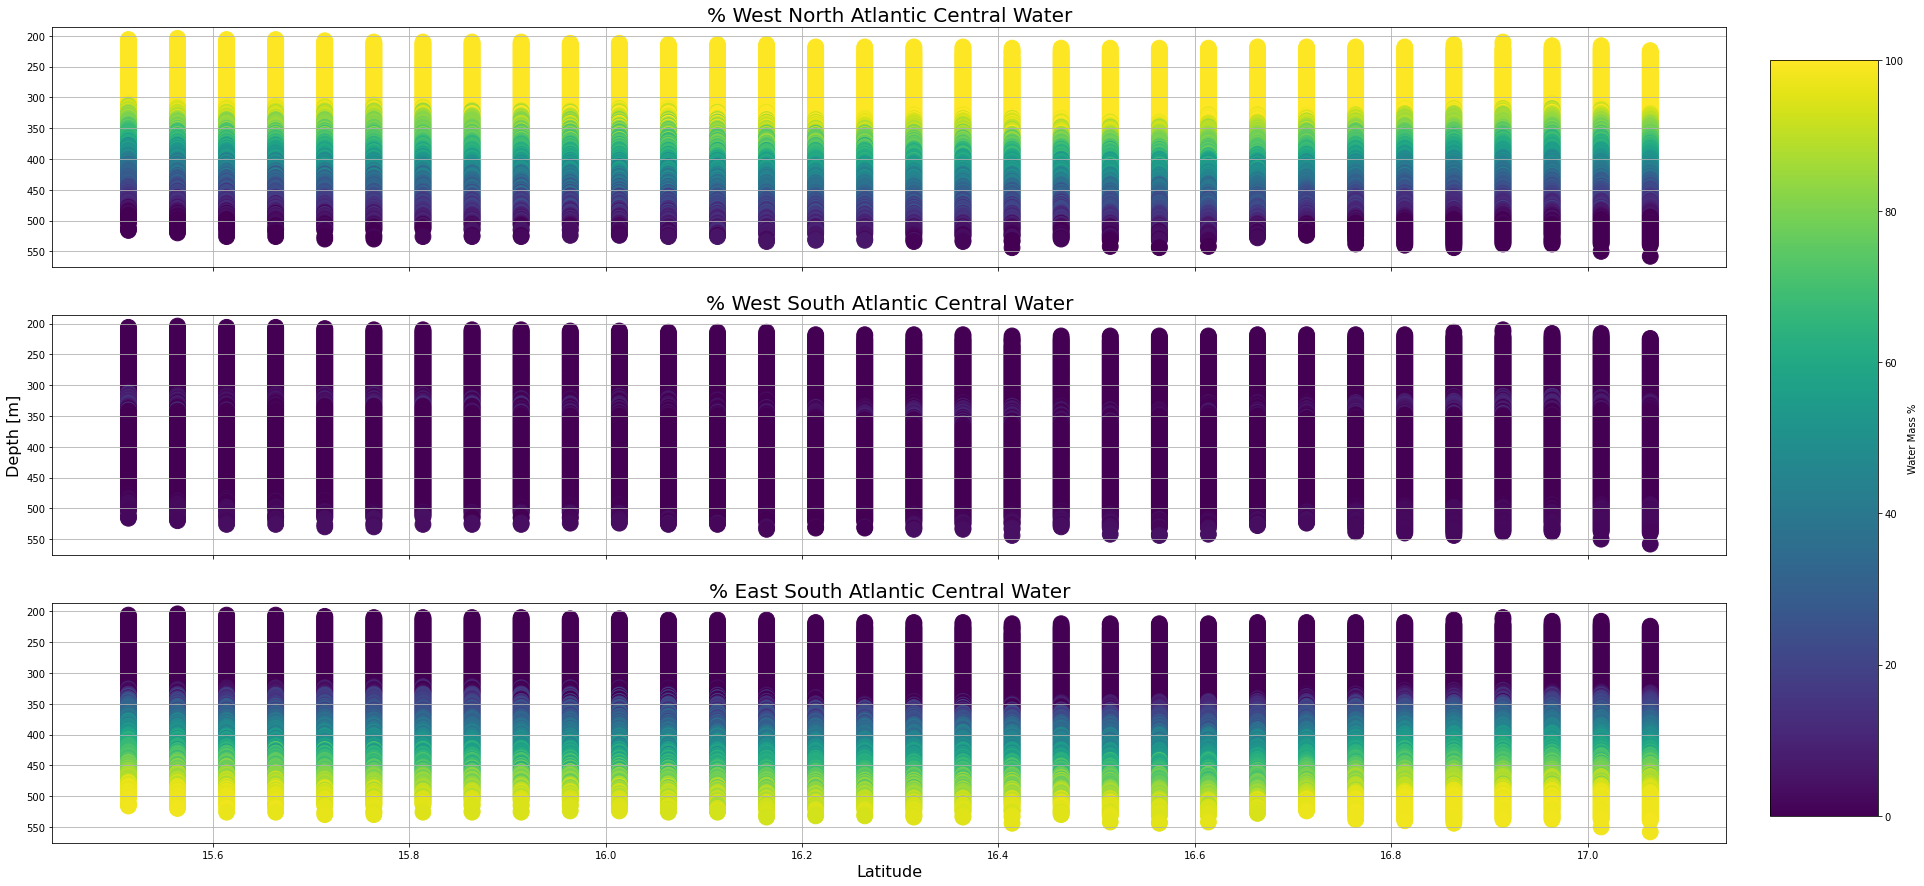

In [32]:
min_range = 0
max_range = len(ompa_soln.obs_df)

f, axes = plt.subplots(figsize=(30,15), nrows = 3, ncols = 1, sharex=True, sharey = True)

sc = axes[0].scatter(ompa_soln.obs_df.latitude[min_range:max_range], ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,0]*100, vmin=0,vmax=100,s=250)
axes[0].invert_yaxis()
axes[0].set_title('% West North Atlantic Central Water', fontsize=20)
axes[0].grid()

axes[1].scatter(ompa_soln.obs_df.latitude[min_range:max_range], ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,1]*100, vmin=0,vmax=100,s=250)
axes[1].invert_yaxis()
axes[1].set_title('% West South Atlantic Central Water', fontsize=20)
axes[1].grid()

axes[2].scatter(ompa_soln.obs_df.latitude[min_range:max_range], ompa_soln.obs_df.depth[min_range:max_range], c=ompa_soln.endmember_fractions[min_range:max_range,2]*100, vmin=0,vmax=100,s=250)
axes[2].invert_yaxis()
axes[2].set_title('% East South Atlantic Central Water', fontsize=20)
axes[2].grid()

axes[1].set_ylabel('Depth [m]', fontsize=16)
axes[2].set_xlabel('Latitude', fontsize=16)

cbar_ax = f.add_axes([0.92, 0.15, 0.05, 0.7])
fbar = f.colorbar(sc, cax=cbar_ax, label='Water Mass %')
#fbar.ax.set_title(fontsize=16)



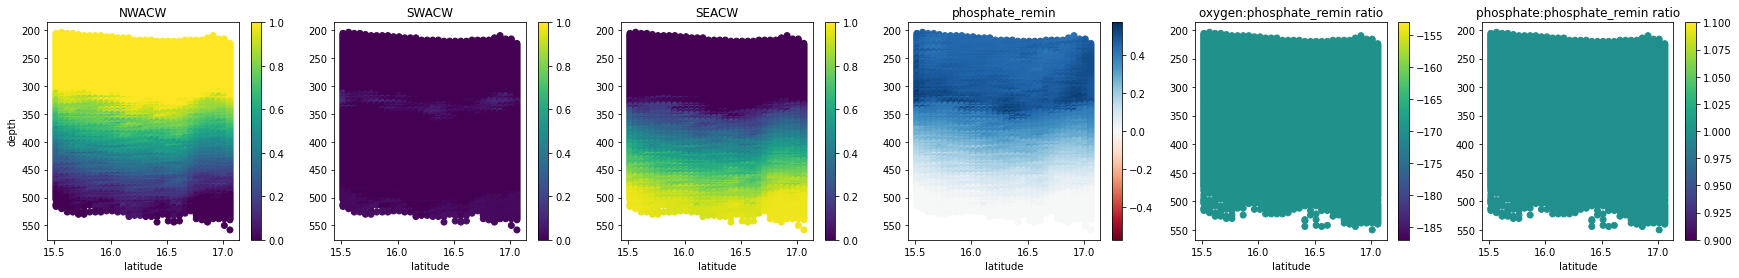

In [33]:
pyompa.plot_ompasoln_endmember_fractions(ompa_soln=ompa_soln,
                                         xaxis_colname="latitude",
                                         yaxis_colname="depth")

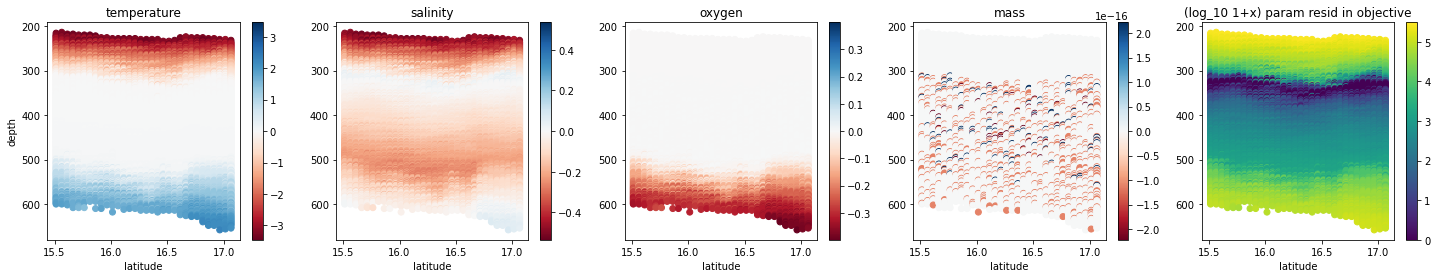

In [29]:
pyompa.plot_ompasoln_residuals(ompa_soln=ompa_soln,
                                  xaxis_colname="latitude",
                                  yaxis_colname="depth")

## What are the next steps here?
1) Determine how robust the definitions are first? So maybe a notebook for some testing where I tweak parameter **weights** by +/- 10% (or something) and show how results change. <br>
2) To evaluate robutness, we look at the variability for each transect across the range of parameter weights. So for 20 trials for transect 1, how does the mean and standard deviation change? <br>
3) Should also loo at the residual of the mass conservation fit..... <br>
4) Then, once the definitions are determined to be robust, write a function to loop through the transects and create endmember fraction datasets for *each* water mass range and save output for each transect. Include metadata and more data from the original raw dataset? <br>
3) 

In [144]:
def OMPA_Sensitivity_Analysis(transport_file):
    global nwacw_sensitivity_df
    global swacw_sensitivity_df
    global seacw_sensitivity_df
    start = time.time()
    
    #sample varying parameter weightings
    sampled_weightings = []
    for i in range(num_samples):
        rand_weighting = dict([
            (key, rng.uniform(value*0.8, value*1.2))
            for key,value in base_weighting.items()
        ])
        sampled_weightings.append(rand_weighting)

    ## Set mass conservation weight equal to whatever has the maximum weight
    for z in np.arange(0,len(sampled_weightings)):
        max_weight = max(sampled_weightings[z], key=sampled_weightings[z].get)
        sampled_weightings[z]['mass'] = sampled_weightings[z][max_weight]

    ds = xr.open_dataset(transport_file, engine='netcdf4')

    rho = gsw.density.rho(ds.salinity, ds.temperature, ds.depth).values
    ds = ds.assign(rho = (['depth','latitude'],rho))
    min_density = 1026
    max_density = 1031

    subset_ds = ds.where((ds.rho>=min_density) & (ds.rho<=max_density),drop=True)
    subset_ds = subset_ds.to_dataframe(dim_order=['latitude','depth'])
    ## Add a column of mass=1 for OMP function constraint
    subset_ds["mass"] = 1.0
    subset_ds = subset_ds.reset_index()

    for x in np.arange(0,num_samples):
        #if  ds.attrs['transect_number'] > 0:
        counter = (ds.attrs['transect_number']*num_samples)+x
        #else:
        #    counter = x
        settings = {"param_names": ["temperature", "salinity",
                        "oxygen", "mass"],
        "convertedparam_groups": convertedparamgroups,
        "param_weightings": sampled_weightings[x],}

        ## This suppresses the print statements from the OMPAProblem() function
        with io.capture_output() as captured:
            ompa_soln = pyompa.OMPAProblem(obs_df = subset_ds, **settings).solve(central_water_FK_endmemberdf,endmember_name_column = "endmember_name")

        nwacw_sensitivity_df['mean'][counter] = np.nanmean(ompa_soln.endmember_fractions[:,0])
        nwacw_sensitivity_df['std'][counter]  = np.nanstd(ompa_soln.endmember_fractions[:,0])
        nwacw_sensitivity_df['temp_weight'][counter]  = sampled_weightings[x]['temperature']
        nwacw_sensitivity_df['sal_weight'][counter]   = sampled_weightings[x]['salinity']
        nwacw_sensitivity_df['mass_weight'][counter]  = sampled_weightings[x]['mass']
        nwacw_sensitivity_df['oxy_weight'][counter]   = sampled_weightings[x]['oxygen']
        nwacw_sensitivity_df['transect_num'][counter] = ds.attrs['transect_number']

        swacw_sensitivity_df['mean'][counter] = np.nanmean(ompa_soln.endmember_fractions[:,1])
        swacw_sensitivity_df['std'][counter]   = np.nanstd(ompa_soln.endmember_fractions[:,1])
        swacw_sensitivity_df['temp_weight'][counter]  = sampled_weightings[x]['temperature']
        swacw_sensitivity_df['sal_weight'][counter]   = sampled_weightings[x]['salinity']
        swacw_sensitivity_df['mass_weight'][counter]  = sampled_weightings[x]['mass']
        swacw_sensitivity_df['oxy_weight'][counter]   = sampled_weightings[x]['oxygen']
        swacw_sensitivity_df['transect_num'][counter] = ds.attrs['transect_number']

        seacw_sensitivity_df['mean'][counter] = np.nanmean(ompa_soln.endmember_fractions[:,2])
        seacw_sensitivity_df['std'][counter]  = np.nanstd(ompa_soln.endmember_fractions[:,2])
        seacw_sensitivity_df['temp_weight'][counter]  = sampled_weightings[x]['temperature']
        seacw_sensitivity_df['sal_weight'][counter]   = sampled_weightings[x]['salinity']
        seacw_sensitivity_df['mass_weight'][counter]  = sampled_weightings[x]['mass']
        seacw_sensitivity_df['oxy_weight'][counter]   = sampled_weightings[x]['oxygen']
        seacw_sensitivity_df['transect_num'][counter] = ds.attrs['transect_number']

    end = time.time()
    elapsed = end-start
    print('DONE Transect #',ds.attrs['transect_number'],'took',elapsed,'seconds')
    ds.close()




In [149]:
transport_files = sorted(glob.glob('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/AOML_Data/Processed_Transport/*'))

rng = np.random.RandomState(1234) #instantiate random number generator with fixed seed
num_samples = 20
base_weighting = paramweightings
nrows = num_samples*len(transport_files)

nwacw_sensitivity_df = pd.DataFrame({'mean':np.repeat(np.nan,nrows), 'std': np.repeat(np.nan,nrows), 'transect_num': np.repeat(np.nan,nrows), 'temp_weight': np.repeat(np.nan,nrows), 'sal_weight': np.repeat(np.nan,nrows), 'oxy_weight': np.repeat(np.nan,nrows), 'mass_weight': np.repeat(np.nan,nrows)})
swacw_sensitivity_df = pd.DataFrame({'mean':np.repeat(np.nan,nrows), 'std': np.repeat(np.nan,nrows), 'transect_num': np.repeat(np.nan,nrows), 'temp_weight': np.repeat(np.nan,nrows), 'sal_weight': np.repeat(np.nan,nrows), 'oxy_weight': np.repeat(np.nan,nrows), 'mass_weight': np.repeat(np.nan,nrows)})
seacw_sensitivity_df = pd.DataFrame({'mean':np.repeat(np.nan,nrows), 'std': np.repeat(np.nan,nrows), 'transect_num': np.repeat(np.nan,nrows), 'temp_weight': np.repeat(np.nan,nrows), 'sal_weight': np.repeat(np.nan,nrows), 'oxy_weight': np.repeat(np.nan,nrows), 'mass_weight': np.repeat(np.nan,nrows)})

## Run the process oxygen data code in parallel for all the deployments (so fast, thanks Mike Smith)
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    executor.map(OMPA_Sensitivity_Analysis, transport_files)



DONE Transect # 102 took 154.84107327461243 seconds
DONE Transect # 105 took 159.03323912620544 seconds
DONE Transect # 103 took 164.8156771659851 seconds
DONE Transect # 104 took 167.46341466903687 seconds
DONE Transect # 101 took 177.31773900985718 seconds
DONE Transect # 100 took 184.08457207679749 seconds
DONE Transect # 10 took 207.1748170852661 seconds
DONE Transect # 1 took 289.49193716049194 seconds
DONE Transect # 106 took 217.90603399276733 seconds
DONE Transect # 11 took 281.5488328933716 seconds
DONE Transect # 109 took 500.436576128006 seconds
DONE Transect # 107 took 518.2136662006378 seconds
DONE Transect # 108 took 514.456953048706 seconds
DONE Transect # 110 took 505.1298930644989 seconds
DONE Transect # 111 took 516.4439189434052 seconds
DONE Transect # 117 took 170.21401190757751 seconds
DONE Transect # 113 took 490.3946919441223 seconds
DONE Transect # 12 took 215.5400390625 seconds
DONE Transect # 13 took 246.42406821250916 seconds
DONE Transect # 114 took 645.7377

In [150]:
test = (nwacw_sensitivity_df.groupby('transect_num')['mean'].max() - nwacw_sensitivity_df.groupby('transect_num')['mean'].min()).values
np.nanmean(test)

/Users/joegradone/opt/anaconda3/envs/glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


nan

In [151]:
nwacw_sensitivity_df['mean'].mean()

nan

In [152]:
nwacw_sensitivity_df

,mean,std,transect_num,temp_weight,sal_weight,oxy_weight,mass_weight
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2335,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2337,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2338,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [313]:
100*(nwacw_sensitivity_df['mean'].max()-nwacw_sensitivity_df['mean'].min())

57.049724812348735

In [314]:
100*(nwacw_sensitivity_df['std'].max()-nwacw_sensitivity_df['std'].min())

33.341782030845316

In [315]:
100*(swacw_sensitivity_df['mean'].max()-swacw_sensitivity_df['mean'].min())

48.81428347286602

In [316]:
100*(swacw_sensitivity_df['std'].max()-swacw_sensitivity_df['std'].min())

39.80877473185201

In [317]:
100*(seacw_sensitivity_df['mean'].max()-seacw_sensitivity_df['mean'].min())

30.661964910567285

In [318]:
100*(seacw_sensitivity_df['std'].max()-seacw_sensitivity_df['std'].min())

26.646548113251058